# Privacy-Preserving Record Linkage (PPRL): Investigating Dataset Extension Attacks

## Preparation

### Imports

Import all relevant libraries and classes used throughout the project. Key components include:

- **Torch** – for tensor operations and neural network functionality  
- **Datasets** – for handling training and evaluation data  
- **PyTorch Models** – custom and pre-defined models for the DEA  
- **Graph Matching Attack (GMA)** – core logic for the initial re-identification phase


In [1]:
import os
import json
from datetime import datetime
import seaborn as sns

from functools import partial  # Import partial from functools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset

import ray
from ray import tune, air
from ray import train
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import tqdm

import numpy as np




from utils import get_hashes, convert_to_two_gram_scores, filter_two_grams, calculate_performance_metrics, run_epoch, label_tensors_to_two_grams, reconstruct_using_ai, reidentification_analysis, clean_result_dict, print_and_save_result, resolve_config, two_gram_overlap, greedy_ngram_reconstruction, reconstruct_using_ai_from_reconstructed_strings

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import hickle as hkl
import string
from early_stopping.early_stopping import EarlyStopping

from graphMatching.gma import run_gma

from datasets.bloom_filter_dataset import BloomFilterDataset
from datasets.tab_min_hash_dataset import TabMinHashDataset
from datasets.two_step_hash_dataset import TwoStepHashDataset

from pytorch_models_hyperparameter_optimization.base_model_hyperparameter_optimization import BaseModelHyperparameterOptimization
from pytorch_models.base_model import BaseModel

print('PyTorch version', torch.__version__)

Using NumPy dot (Mac)
PyTorch version 2.2.0


### Parameters

Configuration and parameters for the Graph Matching Attack (GMA) and Dataset Extension Attack (DEA). For details and possible values, refer to the documentation at ```./docs/parameters.md```.

In [2]:
# Parameters
GLOBAL_CONFIG = {
    "Data": "./data/datasets/fakename_5k.tsv",
    "Overlap": 0.8,
    "DropFrom": "Eve",
    "Verbose": False,  # Print Status Messages
    "MatchingMetric": "cosine",
    "Matching": "MinWeight",
    "Workers": -1,
    "SaveAliceEncs": False,
    "SaveEveEncs": False,
    "DevMode": False,
}


DEA_CONFIG = {
    "DevMode": False,
    # TestSize calculated accordingly
    "TrainSize": 0.8,
    "Patience": 5,
    "MinDelta": 1e-4,
    "NumSamples": 50,
    "Epochs": 15,
    "EarlyStoppingPatience": 5,
    "NumCPU": 11,  # 11 on my local 19 on cluster (general: n-1)
    "MetricToOptimize": "average_recall", # "average_dice", "average_precision", "average_recall", "average_f1"
    "MatchingTechnique": "ai_from_reconstructed_strings",  # "ai", "greedy", "fuzzy", "ai_from_reconstructed_strings"
    "LoadResults": False,
    "LoadPath": "",
    "SaveResults": True,
}

ENC_CONFIG = {
    # TwoStepHash / TabMinHash / BloomFilter
    "AliceAlgo": "BloomFilter",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "None",
    "EveSecret": "ATotallyDifferentString42",
    "EveN": 2,
    "EveMetric": "dice",
    # For BF encoding
    "AliceBFLength": 1024,
    "AliceBits": 10,
    "AliceDiffuse": False,
    "AliceT": 10,
    "AliceEldLength": 1024,
    "EveBFLength": 1024,
    "EveBits": 10,
    "EveDiffuse": False,
    "EveT": 10,
    "EveEldLength": 1024,
    # For TMH encoding
    "AliceNHash": 1024,
    "AliceNHashBits": 64,
    "AliceNSubKeys": 8,
    "Alice1BitHash": True,
    "EveNHash": 1024,
    "EveNHashBits": 64,
    "EveNSubKeys": 8,
    "Eve1BitHash": True,
    # For 2SH encoding
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG",
}

EMB_CONFIG = {
    "Algo": "Node2Vec",
    "AliceQuantile": 0.9,
    "AliceDiscretize": False,
    "AliceDim": 128,
    "AliceContext": 10,
    "AliceNegative": 1,
    "AliceNormalize": True,
    "EveQuantile": 0.9,
    "EveDiscretize": False,
    "EveDim": 128,
    "EveContext": 10,
    "EveNegative": 1,
    "EveNormalize": True,
    # For Node2Vec
    "AliceWalkLen": 100,
    "AliceNWalks": 20,
    "AliceP": 250,
    "AliceQ": 300,
    "AliceEpochs": 5,
    "AliceSeed": 42,
    "EveWalkLen": 100,
    "EveNWalks": 20,
    "EveP": 250,
    "EveQ": 300,
    "EveEpochs": 5,
    "EveSeed": 42
}

ALIGN_CONFIG = {
    "RegWS": max(0.1, GLOBAL_CONFIG["Overlap"]/2), #0005
    "RegInit":1, # For BF 0.25
    "Batchsize": 1, # 1 = 100%
    "LR": 200.0,
    "NIterWS": 100,
    "NIterInit": 5 ,  # 800
    "NEpochWS": 100,
    "LRDecay": 1,
    "Sqrt": True,
    "EarlyStopping": 10,
    "Selection": "None",
    "MaxLoad": None,
    "Wasserstein": True
}

### Dictionaries

In [3]:
# --- Generate a dictionary of all possible 2-grams from letters and digits ---

# Lowercase alphabet: 'a' to 'z'
alphabet = string.ascii_lowercase

# Digits: '0' to '9'
digits = string.digits

# Generate all letter-letter 2-grams (e.g., 'aa', 'ab', ..., 'zz')
letter_letter_grams = [a + b for a in alphabet for b in alphabet]

# Generate all digit-digit 2-grams (e.g., '00', '01', ..., '99')
digit_digit_grams = [d1 + d2 for d1 in digits for d2 in digits]

# Generate all letter-digit 2-grams (e.g., 'a0', 'a1', ..., 'z9')
letter_digit_grams = [l + d for l in alphabet for d in digits]

# Combine all generated 2-grams into one list
all_two_grams = letter_letter_grams + letter_digit_grams + digit_digit_grams

# Create a dictionary mapping index to each 2-gram
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}

## Step 1: Load or Compute Graph Matching Attack (GMA) Results

This code snippet either loads previously computed Graph Matching Attack (GMA) results from disk or runs the attack if no saved data is found.

1. **Generate Configuration Hashes:**  
   The function `get_hashes` creates unique hash values based on the encoding and embedding configurations. These are used to create distinct filenames for the data.

2. **Create File Paths:**  
   Based on the configuration hashes, paths are generated for:
   - Reidentified individuals
   - Not reidentified individuals
   - All individuals in Alice’s dataset (with encoding)

3. **Load Results from Disk (if available):**  
   If the `.h5` files already exist, they are loaded using `hickle` and converted into `pandas.DataFrames`.  
   The data format assumes that the first row contains the column headers, and the rest is the data — hence the slicing `[1:]` and `columns=...`.

4. **Run GMA If Data Is Not Available:**  
   If the files are missing, the GMA is executed via `run_gma()`. The results are again converted to `DataFrames`.


In [4]:
data_dir = os.path.abspath("./data")

eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash = get_hashes(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG)

identifier = f"{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}"

# Define file paths based on the configuration hashes
path_reidentified = f"{data_dir}/available_to_eve/reidentified_individuals_{identifier}.h5"
path_not_reidentified = f"{data_dir}/available_to_eve/not_reidentified_individuals_{identifier}.h5"
path_all = f"{data_dir}/dev/alice_data_complete_with_encoding_{identifier}.h5"

# Check if the output files already exist
if not (os.path.isfile(path_reidentified) and os.path.isfile(path_all) and os.path.isfile(path_not_reidentified)):
    run_gma(
        GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG, ALIGN_CONFIG, DEA_CONFIG,
        eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash
    )

## 🧩 Step 2: Data Preparation

This section initializes the dataset objects depending on which encoding method Alice used. Each encoding requires a different preprocessing strategy for compatibility with downstream neural models.

### 1. Bloom Filter (`"BloomFilter"`)
- Uses binary Bloom filters to represent identifiers.
- Loads `BloomFilterDataset` objects.
- Stores the bit-length of the bloom filter.

### 2. Tabulation MinHash (`"TabMinHash"`)
- Applies a MinHash-based encoding.
- Loads `TabMinHashDataset`.
- Captures the length of each encoded vector.

### 3. Two-Step Hash with One-Hot Encoding (`"TwoStepHash"`)
- Extracts all **unique hash values** to build a consistent one-hot vector space.
- Constructs datasets using `TwoStepHashDatasetOneHotEncoding`.

> ⚙️ All dataset constructors are passed:
> - Whether the data is labeled
> - The full 2-gram list (used as feature tokens)
> - Additional encoding-specific configurations
> - Dev mode toggle (for debugging or smaller runs)


In [5]:
def load_data(data_directory, identifier, load_test=False):
    # Get unique hash identifiers for the encoding and embedding configurations

    data_train = data_val = data_test = None

    if load_test:
        path_not_reidentified = f"{data_directory}/available_to_eve/not_reidentified_individuals_{identifier}.h5"
        path_all = f"{data_directory}/dev/alice_data_complete_with_encoding_{identifier}.h5"
        not_reidentified_data = hkl.load(path_not_reidentified)
        all_data = hkl.load(path_all)
        # Convert lists to DataFrames
        df_not_reidentified = pd.DataFrame(not_reidentified_data[1:], columns=not_reidentified_data[0])
        df_all = pd.DataFrame(all_data[1:], columns=all_data[0])
        df_not_reidentified_labeled = df_all[df_all["uid"].isin(df_not_reidentified["uid"])].reset_index(drop=True)

    # Define file paths based on the configuration hashes
    path_reidentified = f"{data_directory}/available_to_eve/reidentified_individuals_{identifier}.h5"

    reidentified_data = hkl.load(path_reidentified)

    # Convert lists to DataFrames
    df_reidentified = pd.DataFrame(reidentified_data[1:], columns=reidentified_data[0])

    # 1️⃣ Bloom Filter Encoding
    if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
        data_labeled = BloomFilterDataset(
            df_reidentified,
            is_labeled=True,
            all_two_grams=all_two_grams,
            dev_mode=GLOBAL_CONFIG["DevMode"]
        )
        if load_test:
            # If loading validation data, also create a dataset for not reidentified individuals
            data_test = BloomFilterDataset(
                df_not_reidentified_labeled,
                is_labeled=True,
                all_two_grams=all_two_grams,
                dev_mode=GLOBAL_CONFIG["DevMode"]
            )

    # 2️⃣ Tabulation MinHash Encoding
    elif ENC_CONFIG["AliceAlgo"] == "TabMinHash":
        data_labeled = TabMinHashDataset(
            df_reidentified,
            is_labeled=True,
            all_two_grams=all_two_grams,
            dev_mode=GLOBAL_CONFIG["DevMode"]
        )
        if load_test:
            # If loading validation data, also create a dataset for not reidentified individuals
            data_test = TabMinHashDataset(
                df_not_reidentified_labeled,
                is_labeled=True,
                all_two_grams=all_two_grams,
                dev_mode=GLOBAL_CONFIG["DevMode"]
            )

    # 3 Two-Step Hash Encoding (One-Hot Encoding Mode)
    elif ENC_CONFIG["AliceAlgo"] == "TwoStepHash":
        # Collect all unique integers across both reidentified and non-reidentified data
        unique_ints = sorted(set().union(*df_reidentified["twostephash"]))
        data_labeled = TwoStepHashDataset(
            df_reidentified,
            is_labeled=True,
            all_integers=unique_ints,
            all_two_grams=all_two_grams,
            dev_mode=GLOBAL_CONFIG["DevMode"]
        )
        if load_test:
            # If loading validation data, also create a dataset for not reidentified individuals
            data_test = TwoStepHashDataset(
                df_not_reidentified_labeled,
                is_labeled=True,
                all_integers=unique_ints,
                all_two_grams=all_two_grams,
                dev_mode=GLOBAL_CONFIG["DevMode"]
            )

    # Define dataset split proportions
    train_size = int(DEA_CONFIG["TrainSize"] * len(data_labeled))
    val_size = len(data_labeled) - train_size

    # Split the reidentified dataset into training and validation sets
    data_train, data_val = random_split(data_labeled, [train_size, val_size])

    return data_train, data_val, data_test

def load_not_reidentified_data(data_directory, identifier):
    path_not_reidentified = f"{data_directory}/available_to_eve/not_reidentified_individuals_{identifier}.h5"
    path_all = f"{data_directory}/dev/alice_data_complete_with_encoding_{identifier}.h5"
    not_reidentified_data = hkl.load(path_not_reidentified)
    all_data = hkl.load(path_all)
    # Convert lists to DataFrames
    df_not_reidentified = pd.DataFrame(not_reidentified_data[1:], columns=not_reidentified_data[0])
    df_all = pd.DataFrame(all_data[1:], columns=all_data[0])
    df_not_reidentified_labeled = df_all[df_all["uid"].isin(df_not_reidentified["uid"])].reset_index(drop=True).drop("bloomfilter", axis=1)

    return df_not_reidentified_labeled

## Step 3: Hyperparameter Optimization

In [6]:
def train_model(config, data_dir, output_dim, identifier, patience, min_delta):
    # Create DataLoaders for training, validation, and testing

    data_train, data_val, _ = load_data(data_dir, identifier, load_test=False)

    input_dim = data_train[0][0].shape[0]  # Get the input dimension from the first sample

    dataloader_train = DataLoader(
        data_train,
        batch_size=int(config["batch_size"]),
        shuffle=True  # Important for training
    )

    dataloader_val = DataLoader(
        data_val,
        batch_size=int(config["batch_size"]),
        shuffle=True  # Allows variation in validation batches
    )

    train_losses = []
    val_losses = []
    total_precision = total_recall = total_f1 = total_dice = total_val_loss = 0.0
    n = len(dataloader_val.dataset)
    epochs = 0
    early_stopper = EarlyStopping(patience=patience, min_delta=min_delta)

    # Define and initialize model with hyperparameters from config
    model = BaseModelHyperparameterOptimization(
        input_dim=input_dim,
        output_dim=output_dim,
        num_layers=config["num_layers"],
        hidden_layer_size=config["hidden_layer_size"],
        dropout_rate=config["dropout_rate"],
        activation_fn=config["activation_fn"]
    )

    # Set device for model (GPU or CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Select loss function based on config
    loss_functions = {
        "BCEWithLogitsLoss": nn.BCEWithLogitsLoss(),
        "MultiLabelSoftMarginLoss": nn.MultiLabelSoftMarginLoss(),
        "SoftMarginLoss": nn.SoftMarginLoss(),
    }
    criterion = loss_functions[config["loss_fn"]]

    learning_rate = config["optimizer"]["lr"].sample()
    # Select optimizer based on config
    optimizers = {
        "Adam": lambda: optim.Adam(model.parameters(), lr=learning_rate),
        "AdamW": lambda: optim.AdamW(model.parameters(), lr=learning_rate),
        "SGD": lambda: optim.SGD(model.parameters(), lr=learning_rate, momentum=config["optimizer"]["momentum"].sample()),
        "RMSprop": lambda: optim.RMSprop(model.parameters(), lr=learning_rate)
    }
    optimizer = optimizers[config["optimizer"]["name"]]()

    schedulers = {
        "StepLR": lambda: torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=config["lr_scheduler"]["step_size"].sample(),
            gamma=config["lr_scheduler"]["gamma"].sample()
        ),
        "ExponentialLR": lambda: torch.optim.lr_scheduler.ExponentialLR(
            optimizer,
            gamma=config["lr_scheduler"]["gamma"].sample()
        ),
        "ReduceLROnPlateau": lambda: torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode=config["lr_scheduler"]["mode"],
            factor=config["lr_scheduler"]["factor"].sample(),
            patience=config["lr_scheduler"]["patience"].sample()
        ),
        "CosineAnnealingLR": lambda: torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=config["lr_scheduler"]["T_max"].sample(),
            eta_min=config["lr_scheduler"]["eta_min"].sample()
        ),
        "CyclicLR": lambda: torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=config["lr_scheduler"]["base_lr"].sample(),
            max_lr=config["lr_scheduler"]["max_lr"].sample(),
            step_size_up=config["lr_scheduler"]["step_size_up"].sample(),
            mode=config["lr_scheduler"]["mode_cyclic"].sample(),
            cycle_momentum=False
        ),
        "None": lambda: None,
    }
    scheduler = schedulers[config["lr_scheduler"]["name"]]()

    # Training loop
    for _ in range(DEA_CONFIG["Epochs"]):
        epochs += 1
        # Training phase
        model.train()
        train_loss = run_epoch(model, dataloader_train, criterion, optimizer, device, is_training=True, verbose=GLOBAL_CONFIG["Verbose"], scheduler=scheduler)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = run_epoch(model, dataloader_val, criterion, optimizer, device, is_training=False, verbose=GLOBAL_CONFIG["Verbose"], scheduler=scheduler)
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        val_losses.append(val_loss)
        total_val_loss += val_loss

         # Early stopping check
        if early_stopper(val_loss):
            break

    # Test phase with reconstruction and evaluation
    model.eval()

    with torch.no_grad():
        for data, labels, _ in dataloader_val:

            actual_two_grams = label_tensors_to_two_grams(two_gram_dict, labels)

            # Move data to device and make predictions
            data = data.to(device)
            logits = model(data)
            probabilities = torch.sigmoid(logits)

            # Convert probabilities into 2-gram scores
            batch_two_gram_scores = convert_to_two_gram_scores(two_gram_dict, probabilities)

            # Filter out low-scoring 2-grams
            batch_filtered_two_gram_scores = filter_two_grams(batch_two_gram_scores, config["threshold"])

            # Calculate performance metrics for evaluation
            dice, precision, recall, f1 = calculate_performance_metrics(
                actual_two_grams, batch_filtered_two_gram_scores)

            total_dice += dice
            total_precision += precision
            total_recall += recall
            total_f1 += f1

    train.report({
            "average_dice": total_dice / n,
            "average_precision": total_precision / n,
            "average_recall": total_recall / n,
            "average_f1": total_f1 / n,
            "total_val_loss": total_val_loss,
            "len_train": len(dataloader_train.dataset),
            "len_val": len(dataloader_val.dataset),
            "epochs": epochs
        })

In [7]:
# Define search space for hyperparameter optimization
search_space = {
    "output_dim": len(all_two_grams),  # Output dimension is also the number of unique 2-grams
    #"num_layers": tune.randint(1, 8),  # Vary the number of layers in the model
    "num_layers": tune.randint(1, 2),
    #"hidden_layer_size": tune.choice([64, 128, 256, 512, 1024, 2048]),  # Different sizes for hidden layers
    "hidden_layer_size": tune.choice([1024, 2048]),  # Different sizes for hidden layers
    "dropout_rate": tune.uniform(0.1, 0.4),  # Dropout rate between 0.1 and 0.4
    "activation_fn": tune.choice(["relu", "leaky_relu", "gelu", "elu", "selu", "tanh"]),  # Activation functions to choose from
    "optimizer": tune.choice([
        {"name": "Adam", "lr": tune.loguniform(1e-5, 1e-3)},
        {"name": "AdamW", "lr": tune.loguniform(1e-5, 1e-3)},
        {"name": "SGD", "lr": tune.loguniform(1e-4, 1e-2), "momentum": tune.uniform(0.0, 0.99)},
        {"name": "RMSprop", "lr": tune.loguniform(1e-5, 1e-3)},
    ]),
    "loss_fn": tune.choice(["BCEWithLogitsLoss", "MultiLabelSoftMarginLoss", "SoftMarginLoss"]),
    "threshold": tune.uniform(0.3, 0.8),
    "lr_scheduler": tune.choice([
        {"name": "StepLR", "step_size": tune.choice([5, 10, 20]), "gamma": tune.uniform(0.1, 0.9)},
        {"name": "ExponentialLR", "gamma": tune.uniform(0.85, 0.99)},
        {"name": "ReduceLROnPlateau", "mode": "min", "factor": tune.uniform(0.1, 0.5), "patience": tune.choice([5, 10, 15])},
        {"name": "CosineAnnealingLR", "T_max": tune.loguniform(10, 50) , "eta_min": tune.choice([1e-5, 1e-6, 0])},
        {"name": "CyclicLR", "base_lr": tune.loguniform(1e-5, 1e-3), "max_lr": tune.loguniform(1e-3, 1e-1), "step_size_up": tune.choice([2000, 4000]), "mode_cyclic": tune.choice(["triangular", "triangular2", "exp_range"]) },
        {"name": "None"}  # No scheduler
    ]),
    "batch_size": tune.choice([8, 16, 32, 64]),  # Batch sizes to test
}

selected_dataset = GLOBAL_CONFIG["Data"].split("/")[-1].replace(".tsv", "")

experiment_tag = "experiment_" + ENC_CONFIG["AliceAlgo"] + "_" + selected_dataset + "_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Initialize Ray for hyperparameter optimization
ray.init(ignore_reinit_error=True)

# Optuna Search Algorithm for optimizing the hyperparameters
optuna_search = OptunaSearch(metric=DEA_CONFIG["MetricToOptimize"], mode="max")

# Use ASHAScheduler to manage trials and early stopping
scheduler = ASHAScheduler(metric="total_val_loss", mode="min")

# Define and configure the Tuner for Ray Tune
tuner = tune.Tuner(
    partial(train_model, data_dir=data_dir, output_dim=len(all_two_grams), identifier=identifier , patience=DEA_CONFIG["Patience"], min_delta=DEA_CONFIG["MinDelta"]),  # The function to optimize (training function)
    tune_config=tune.TuneConfig(
        search_alg=optuna_search,  # Search strategy using Optuna
        scheduler=scheduler,  # Use ASHA to manage the trials
        num_samples=DEA_CONFIG["NumSamples"],  # Number of trials to run
        max_concurrent_trials=DEA_CONFIG["NumCPU"],
    ),
    param_space=search_space  # Pass in the defined hyperparameter search space
)

# Run the tuner
results = tuner.fit()

# Shut down Ray after finishing the optimization
ray.shutdown()

(raylet) [2025-06-10 11:09:01,869 E 48920 1468863] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-06-10_11-08-49_766900_47907 is over 95% full, available space: 10048061440; capacity: 494384795648. Object creation will fail if spilling is required.
2025-06-10 11:09:10,718	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'optimizer/lr': <ray.tune.search.sample.Float object at 0x34fea0f10>, 'lr_scheduler/factor': <ray.tune.search.sample.Float object at 0x34fea0cd0>, 'lr_scheduler/patience': <ray.tune.search.sample.Categorical object at 0x34fea0fa0>}
2025-06-10 11:09:11,633	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'optimizer/lr': <ray.tune.search.sample.Float object at 0x354308910>, 'lr_scheduler/base_lr': <ray.tune.search.sample.Float object at 0x3543088e0>, 'lr_scheduler/max_lr': <ray.tune.search.sample.Float object at 0x3543089a0>, 'lr_scheduler/step_size_up': <

In [8]:
result_grid = results
best_result = result_grid.get_best_result(metric="average_dice", mode="max")

✅ Results saved to all_trial_results.csv

🔍 Best_Result
----------------------------------------
Config: {'output_dim': 1036, 'num_layers': 1, 'hidden_layer_size': 1024, 'dropout_rate': 0.2945876690474791, 'activation_fn': 'elu', 'optimizer': {'name': 'RMSprop', 'lr': 2.6113353459112038e-05}, 'loss_fn': 'BCEWithLogitsLoss', 'threshold': 0.3580070791394996, 'lr_scheduler': {'name': 'CyclicLR', 'base_lr': 5.0678659671797315e-05, 'max_lr': 0.023852832134189064, 'step_size_up': 4000, 'mode_cyclic': 'exp_range'}, 'batch_size': 16}
Average Dice: 0.9254
Average Precision: 0.9682
Average Recall: 0.8904
Average F1: 0.9254

🔍 Worst_Result
----------------------------------------
Config: {'output_dim': 1036, 'num_layers': 1, 'hidden_layer_size': 1024, 'dropout_rate': 0.1776782815840499, 'activation_fn': 'relu', 'optimizer': {'name': 'SGD', 'lr': 0.0007892197574418948, 'momentum': 0.4267453116950934}, 'loss_fn': 'MultiLabelSoftMarginLoss', 'threshold': 0.792123289800817, 'lr_scheduler': {'name': '

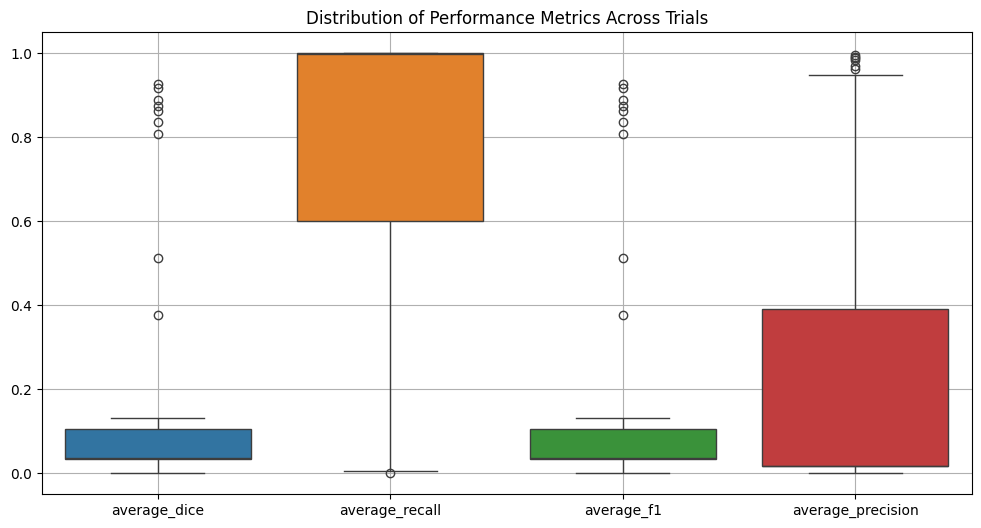

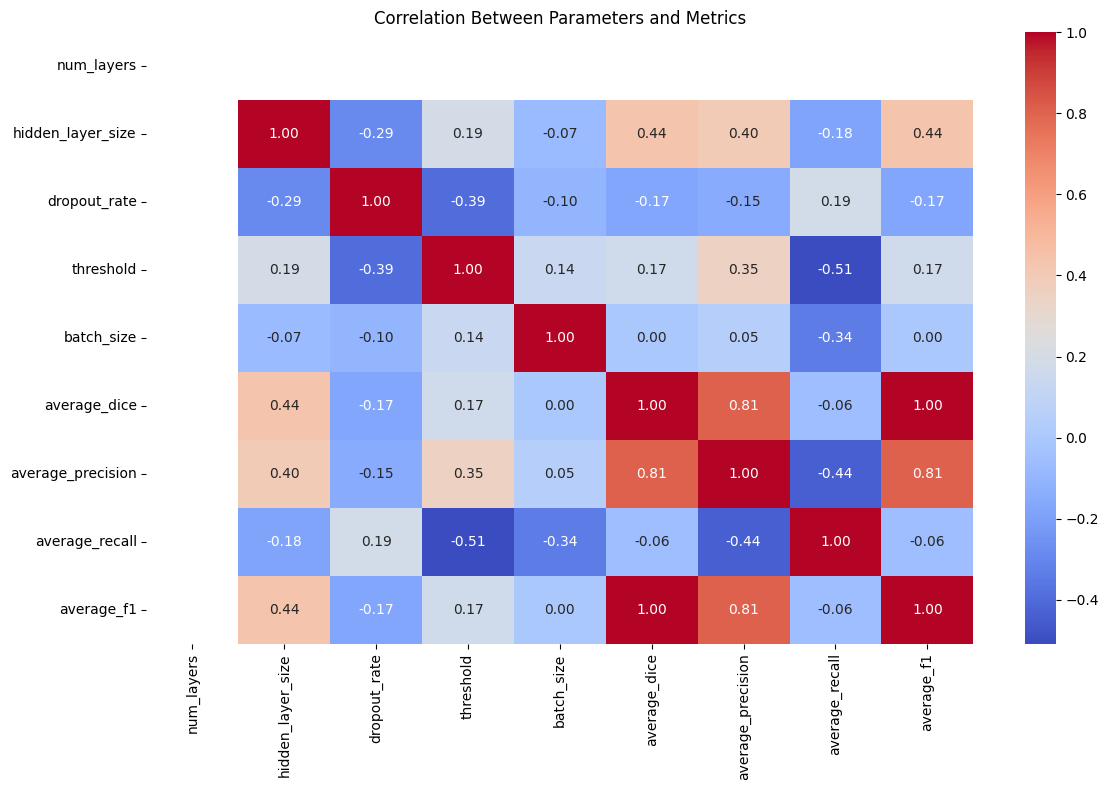

In [9]:
if DEA_CONFIG["SaveResults"]:
    save_to = f"experiment_results/{experiment_tag}"
    os.makedirs(save_to, exist_ok=True)
    worst_result = result_grid.get_best_result(metric="average_dice", mode="min")

    # Combine configs and metrics into a DataFrame
    df = pd.DataFrame([
        {
            **clean_result_dict(resolve_config(result.config)),
            **{k: result.metrics.get(k) for k in ["average_dice", "average_precision", "average_recall", "average_f1"]},
        }
        for result in result_grid
    ])

    # Save to CSV
    df.to_csv(f"{save_to}/all_trial_results.csv", index=False)
    print("✅ Results saved to all_trial_results.csv")

    print_and_save_result("Best_Result", best_result, save_to)
    print_and_save_result("Worst_Result", worst_result, save_to)

    # Compute and print average metrics
    print("\n📊 Average Metrics Across All Trials")
    avg_metrics = df[["average_dice", "average_precision", "average_recall", "average_f1"]].mean()
    print("-" * 40)
    for key, value in avg_metrics.items():
        print(f"{key.capitalize()}: {value:.4f}")

    # --- 📈 Plotting performance metrics ---
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[["average_dice", "average_recall", "average_f1", "average_precision"]])
    plt.title("Distribution of Performance Metrics Across Trials")
    plt.grid(True)
    plt.savefig(f"{save_to}/metric_distributions.png")
    print("📊 Saved plot: metric_distributions.png")

    # --- 📌 Correlation between config params and performance ---
    # Only include numeric config columns
    exclude_cols = {"input_dim", "output_dim"}
    numeric_config_cols = [
        col for col in df.columns
        if pd.api.types.is_numeric_dtype(df[col]) and col not in exclude_cols
    ]
    correlation_df = df[numeric_config_cols].corr()

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Between Parameters and Metrics")
    plt.tight_layout()
    plt.savefig(f"{save_to}/correlation_heatmap.png")
    print("📌 Saved heatmap: correlation_heatmap.png")


## Step 4: Model Training

The neural network model is selected dynamically based on the encoding technique used for Alice’s data.

### Supported Models:

- **BloomFilter** → `BloomFilterToTwoGramClassifier`  
  - Input: Binary vector (Bloom filter)  
  - Output: 2-gram prediction

- **TabMinHash** → `TabMinHashToTwoGramClassifier`  
  - Input: Tabulated MinHash signature  
  - Output: 2-gram prediction

- **TwoStepHash** → `TwoStepHashToTwoGramClassifier`  
  - Input: Length of the unique integers present
  - Output: 2-gram predicition
    
Each model outputs predictions over the set of all possible 2-grams (`all_two_grams`), and the input dimension is dynamically configured based on the dataset.


In [10]:
best_config = resolve_config(best_result.config)
data_train, data_val, data_test = load_data(data_dir, identifier, load_test=True)
input_dim=data_train[0][0].shape[0]

dataloader_train = DataLoader(
    data_train,
    batch_size=int(best_config.get("batch_size", 32)),  # Default to 32 if not specified
    shuffle=True  # Important for training
)

dataloader_val = DataLoader(
    data_val,
    batch_size=int(best_config.get("batch_size", 32)),
    shuffle=True  # Allows variation in validation batches
)

dataloader_test = DataLoader(
    data_test,
    batch_size=int(best_config.get("batch_size", 32)),
    shuffle=True  # Allows variation in validation batches
)

In [11]:
model = BaseModel(
            input_dim=input_dim,
            output_dim=len(all_two_grams),
            hidden_layer=best_config.get("hidden_layer_size", 128),  # Default to 128 if not specified
            num_layers=best_config.get("num_layers", 2),  # Default to 2 if not specified
            dropout_rate=best_config.get("dropout_rate", 0.2),  # Default to 0.2 if not specified
            activation_fn=best_config.get("activation_fn", "relu")  # Default to 'relu' if not specified
        )
print(model)

BaseModel(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.2945876690474791, inplace=False)
    (3): Linear(in_features=1024, out_features=1036, bias=True)
  )
)


## Training Environment Setup
This code initializes the core components needed for training a neural network model.

1. TensorBoard Setup
    - Creates unique run name by combining:
    - Loss function type
    - Optimizer choice
    - Alice's algorithm
    - Initializes TensorBoard writer in runs directory
2. Device Configuration
    - Automatically selects GPU if available, falls back to CPU
    - Moves model to selected device
3. Loss Functions
    - `BCEWithLogitsLoss`: Binary Cross Entropy with Logits
    - `MultiLabelSoftMarginLoss`: Multi-Label Soft Margin Loss
4. Optimizers:
    - `Adam`: Adaptive Moment Estimation
    - `AdamW`: Adam with Weight Decay
    - `SGD`: Stochastic Gradient Descent (with momentum)
    - `RMSprop`: Root Mean Square Propagation

In [12]:
if DEA_CONFIG["SaveResults"]:
    # Setup tensorboard logging
    run_name = "".join([
        best_config.get("loss_fn", "MultiLabelSoftMarginLoss"),
        best_config.get("optimizer").get("name", "Adam"),
        ENC_CONFIG["AliceAlgo"],
        best_config.get("activation_fn", "relu"),
    ])
    tb_writer = SummaryWriter(f"{save_to}/{run_name}")

# Setup compute device (GPU/CPU)
compute_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(compute_device)

# Initialize loss function
match best_config.get("loss_fn", "MultiLabelSoftMarginLoss"):
    case "BCEWithLogitsLoss":
        criterion = nn.BCEWithLogitsLoss(reduction='mean')
    case "MultiLabelSoftMarginLoss":
        criterion = nn.MultiLabelSoftMarginLoss(reduction='mean')
    case "SoftMarginLoss":
        criterion = nn.SoftMarginLoss()
    case _:
        raise ValueError(f"Unsupported loss function: {best_config.get('loss_fn', 'MultiLabelSoftMarginLoss')}")

# Initialize optimizer
match best_config.get("optimizer").get("name", "Adam"):
    case "Adam":
        optimizer = optim.Adam(model.parameters(), lr=best_config.get("optimizer").get("lr"))
    case "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=best_config.get("optimizer").get("lr"))
    case "SGD":
        optimizer = optim.SGD(model.parameters(),
                            lr=best_config.get("optimizer").get("lr"),
                            momentum=best_config.get("optimizer").get("momentum"))
    case "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=best_config.get("optimizer").get("lr"))
    case _:
        raise ValueError(f"Unsupported optimizer: {best_config.get('optimizer').get('name', 'Adam')}")

# Initialize learning rate scheduler
match best_config.get("lr_scheduler").get("name", "None"):
    case "StepLR":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=best_config.get("lr_scheduler").get("step_size"),
            gamma=best_config.get("lr_scheduler").get("gamma")
        )
    case "ExponentialLR":
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer,
            gamma=best_config.get("lr_scheduler").get("gamma")
        )
    case "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode=best_config.get("lr_scheduler").get("mode"),
            factor=best_config.get("lr_scheduler").get("factor"),
            patience=best_config.get("lr_scheduler").get("patience")
        )
    case "CosineAnnealingLR":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=best_config.get("lr_scheduler").get("T_max")
        )
    case "CyclicLR":
        scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=best_config.get("lr_scheduler").get("base_lr"),
            max_lr=best_config.get("lr_scheduler").get("max_lr"),
            step_size_up=best_config.get("lr_scheduler").get("step_size_up"),
            mode=best_config.get("lr_scheduler").get("mode_cyclic"),
            cycle_momentum=False  # usually False for Adam/AdamW
        )
    case None | "None":
        scheduler = None
    case _:
        raise ValueError(f"Unsupported LR scheduler: {best_config.get('lr_scheduler').get('name', 'None')}")

## Model Training with Early Stopping

The function `train_model` orchestrates the training process for the neural network, including both training and validation phases for each epoch. It also utilizes **early stopping** to halt training when the validation loss fails to improve over multiple epochs, avoiding overfitting.

### Key Phases:
1. **Training Phase**: 
   - The model is trained on the `dataloader_train`, computing the training loss using the specified loss function (`criterion`) and optimizer. Gradients are calculated, and the model parameters are updated.
  
2. **Validation Phase**:
   - The model is evaluated on the `dataloader_val` without updating weights. The validation loss is computed to track model performance on unseen data.

3. **Logging**: 
   - Training and validation losses are logged to both the console and **TensorBoard** for tracking model performance during training.

4. **Early Stopping**: 
   - If the validation loss does not improve after a certain number of epochs (defined by `DEA_CONFIG["Patience"]`), the training process is halted to prevent overfitting.

### Helper Functions:
- `run_epoch`: Handles a single epoch, either for training or validation, depending on the flag `is_training`.
- `log_metrics`: Logs the training and validation losses to the console and TensorBoard for each epoch.


In [13]:
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    val_loss = train_loss = 0.0
    early_stopper = EarlyStopping(patience=DEA_CONFIG["EarlyStoppingPatience"], min_delta=DEA_CONFIG["MinDelta"], verbose=GLOBAL_CONFIG["Verbose"])

    for epoch in range(best_config.get("epochs", DEA_CONFIG["Epochs"])):  # Use best_config epochs or default to DEA_CONFIG
        # Training phase
        model.train()
        train_loss = run_epoch(
            model, dataloader_train, criterion, optimizer,
            device, is_training=True, verbose=GLOBAL_CONFIG["Verbose"], scheduler=scheduler
        )
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = run_epoch(
            model, dataloader_val, criterion, optimizer,
            device, is_training=False, verbose=GLOBAL_CONFIG["Verbose"], scheduler=scheduler
        )
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        val_losses.append(val_loss)

        # Logging
        log_metrics(train_loss, val_loss, epoch, best_config.get("epochs", DEA_CONFIG["Epochs"]))

        # Early stopping check
        if early_stopper(val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    return train_losses, val_losses

def log_metrics(train_loss, val_loss, epoch, total_epochs):
    print(f"Epoch {epoch + 1}/{total_epochs} - "
          f"Train loss: {train_loss:.4f}, "
          f"Validation loss: {val_loss:.4f}")
    if DEA_CONFIG["SaveResults"]:
        tb_writer.add_scalar("Loss/train", train_loss, epoch + 1)
        tb_writer.add_scalar("Loss/validation", val_loss, epoch + 1)

train_losses, val_losses = train_model(
    model, dataloader_train, dataloader_val,
    criterion, optimizer, compute_device
    )

Epoch 1/15 - Train loss: 0.0536, Validation loss: 0.0316
Epoch 2/15 - Train loss: 0.0205, Validation loss: 0.0203
Epoch 3/15 - Train loss: 0.0163, Validation loss: 0.0230
Epoch 4/15 - Train loss: 0.0206, Validation loss: 0.0361
Epoch 5/15 - Train loss: 0.0284, Validation loss: 0.0457
Epoch 6/15 - Train loss: 0.0364, Validation loss: 0.0608
Epoch 7/15 - Train loss: 0.0474, Validation loss: 0.0819
Early stopping triggered at epoch 7


## Loss Visualization over Epochs

This code snippet generates a plot to visualize the **training loss** and **validation loss** across epochs. It's useful for tracking model performance during training and evaluating if overfitting is occurring (i.e., when validation loss starts increasing while training loss continues to decrease).

### Key Elements:
1. **Plotting the Losses**: 
   - The `train_losses` and `val_losses` are plotted over the epochs. 
   - The **blue line** represents the training loss, and the **red line** represents the validation loss.

2. **Legend**: 
   - A legend is added to distinguish between training and validation losses.

3. **Title and Labels**: 
   - The plot is titled "Training and Validation Loss over Epochs" for context.
   - **X-axis** represents the epoch number, and **Y-axis** represents the loss value.


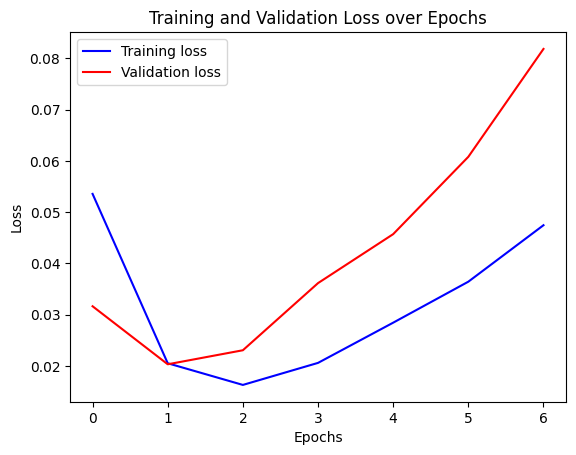

In [14]:
# Plot the training and validation losses over epochs
plt.plot(train_losses, label='Training loss', color='blue')
plt.plot(val_losses, label='Validation loss', color='red')

# Adding a legend to the plot
plt.legend()

# Setting the title and labels for clarity
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Show the plot
plt.show()

## Step 5: Application to Encoded Data

This code performs inference on the test data and compares the predicted 2-grams with the actual 2-grams, providing a performance evaluation based on the **Dice similarity coefficient**.

### Key Steps:

1. **Prepare for Evaluation**:
   - The model is switched to **evaluation mode** (`model.eval()`), ensuring no gradient computation.
   
2. **Thresholding**:
   - A threshold (`DEA_CONFIG["FilterThreshold"]`) is applied to filter out low-probability predictions, retaining only the most confident predictions.

3. **Inference and 2-Gram Scoring**:
   - The model is applied to the batch, and the **logits** are converted into probabilities using the **sigmoid function**.
   - The probabilities are then mapped to **2-gram scores**, and scores below the threshold are discarded.

4. **Reconstructing Words**:
   - For each sample in the batch, **2-grams** are reconstructed into words based on the filtered scores.

5. **Performance Metrics**:
   - The actual 2-grams (from the test dataset) are compared with the predicted 2-grams, and the **Dice similarity coefficient** is calculated for each sample.

### Result:
- The code generates a list `combined_results_performance`, which contains a detailed comparison for each UID, including:
  - **Actual 2-grams** (from the test data)
  - **Predicted 2-grams** (from the model)
  - **Dice similarity** score indicating how similar the actual and predicted 2-grams are.

In [15]:
#save_to = "experiment_results/experiment_BloomFilter_fakename_5k_2025-06-06_14-19-00" # overwrite if necessary
base_path = DEA_CONFIG["LoadPath"] if DEA_CONFIG["LoadResults"] else save_to
base_path = os.path.join(base_path, "trained_model")
model_file = os.path.join(base_path, "model.pt")
config_file = os.path.join(base_path, "config.json")
result_file = os.path.join(base_path, "result.json")
metrics_file = os.path.join(base_path, "metrics.txt")

In [16]:
if DEA_CONFIG["SaveResults"]:
    print(f"Saving results to {save_to}")
    os.makedirs(base_path, exist_ok=True)
    torch.save(model.state_dict(), model_file)
    with open(config_file, "w") as f:
        json.dump(best_config, f, indent=4)

Saving results to experiment_results/experiment_BloomFilter_fakename_5k_2025-06-10_11-08-49


In [17]:
if DEA_CONFIG["LoadResults"]:
    with open(config_file) as f:
        best_config = json.load(f)

    model = BaseModel(
        input_dim=1024,
        output_dim=1036,
        hidden_layer=best_config.get("hidden_layer_size", 128),  # Default to 128 if not specified
        num_layers=best_config.get("num_layers", 2),  # Default to 2 if not specified
        dropout_rate=best_config.get("dropout_rate", 0.2),  # Default to 0.2 if not specified
        activation_fn=best_config.get("activation_fn", "relu")  # Default to 'relu' if not specified
    )
    # Load model
    model.load_state_dict(torch.load(model_file))
    model.eval()

In [18]:
# List to store decoded 2-gram scores for all test samples

decoded_test_results_words = []
result = []
total_precision = total_recall = total_f1 = total_dice = 0.0
n = len(dataloader_test.dataset)

# Switch to evaluation mode (no gradient computation during inference)
model.eval()

# Define Threshold for filtering predictions
threshold = best_config.get("threshold", 0.5)  # Default threshold if not specified

# Loop through the test dataloader for inference
with torch.no_grad():  # No need to compute gradients during inference
    for data, labels, uid in tqdm(dataloader_test, desc="Test loop") if GLOBAL_CONFIG["Verbose"] else dataloader_test:

        actual_two_grams = label_tensors_to_two_grams(two_gram_dict, labels)

        # Move data to device and make predictions
        data = data.to(compute_device)
        logits = model(data)
        probabilities = torch.sigmoid(logits)

        # Convert probabilities into 2-gram scores
        batch_two_gram_scores = convert_to_two_gram_scores(two_gram_dict, probabilities)

        # Filter out low-scoring 2-grams
        batch_filtered_two_gram_scores = filter_two_grams(batch_two_gram_scores, threshold)

        # Calculate performance metrics for evaluation
        dice, precision, recall, f1 = calculate_performance_metrics(
            actual_two_grams, batch_filtered_two_gram_scores)
        total_dice += dice
        total_precision += precision
        total_recall += recall
        total_f1 += f1

        for two_grams, two_grams_predicted, uid in zip(actual_two_grams, batch_filtered_two_gram_scores, uid):
            # Create a dictionary to store the results for each test sample
            result_dict = {
                "uid": uid,
                "actual_two_grams": two_grams,
                "filtered_two_grams": two_grams_predicted,
            }
            # Append the result dictionary to the combined results list
            result.append(result_dict)

        average_precision = total_precision / n
        average_recall = total_recall / n
        average_f1 = total_f1 / n
        average_dice = total_dice / n


# Now `combined_results_performance` contains detailed comparison for all test samples
print (f"Average Precision: {average_precision}")
print (f"Average Recall: {average_recall}")
print (f"Average F1 Score: {average_f1}")
print (f"Average Dice Similarity: {average_dice}")


Average Precision: 0.8731196900650905
Average Recall: 0.7687849045221803
Average F1 Score: 0.8129975660660054
Average Dice Similarity: 0.8129977022977023


In [19]:
# SAVE - Metrics and Result
if DEA_CONFIG["SaveResults"]:
    with open(metrics_file, "w") as f:
        f.write(f"Average Precision: {average_precision:.4f}\n")
        f.write(f"Average Recall: {average_recall:.4f}\n")
        f.write(f"Average F1 Score: {average_f1:.4f}\n")
        f.write(f"Average Dice Similarity: {average_dice:.4f}\n")

    with open(result_file, 'w', encoding='utf-8') as f:
        json.dump(result, f, indent=4, ensure_ascii=False)


In [20]:
# LOAD - Result
if DEA_CONFIG["LoadResults"]:
    with open(result_file, 'r', encoding='utf-8') as f:
        result = json.load(f)


## Visualize Performance for Re-Identification

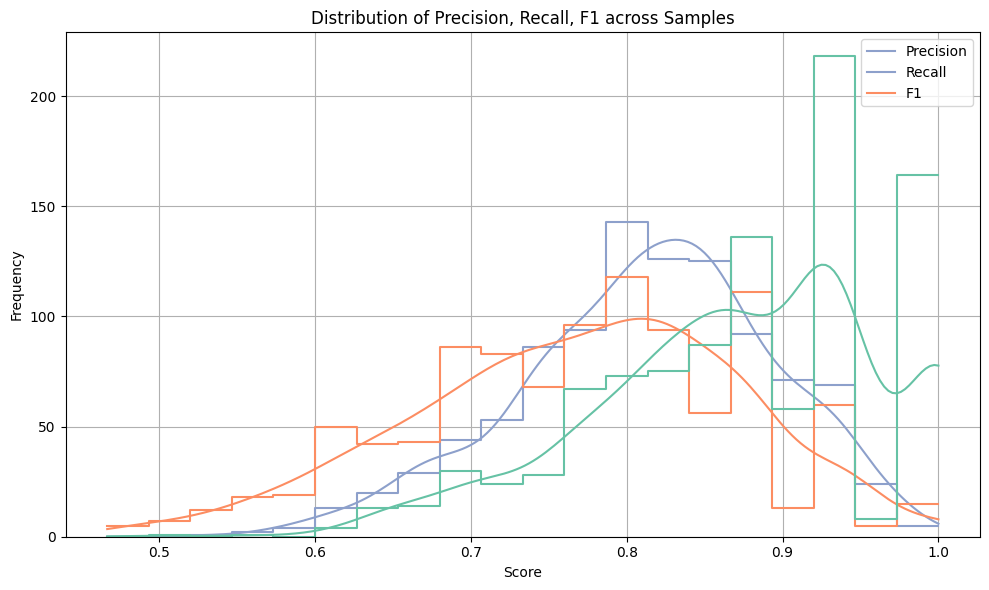


🔍 Sample Reconstructions (first 5):
UID: 44023
  Actual 2-grams:       ['ad', 'as', 'ck', 'dr', 'el', 'ha', 'ic', 'is', 'li', 'me', 'ri', 'sa', 'sh', 'ss', 'k1', '11', '12', '19', '26', '61', '86', '98']
  Predicted 2-grams:    ['as', 'el', 'ic', 'is', 'li', 'pl', 'ri', 'sa', 'ss', '19', '26', '61', '62', '66', '98']
------------------------------------------------------------
UID: 6707
  Actual 2-grams:       ['ar', 'be', 'er', 'la', 'ob', 'ro', 'rr', 'rt', 'ry', 'tl', 'y7', '11', '19', '21', '69', '72', '96']
  Predicted 2-grams:    ['ar', 'be', 'er', 'la', 'ob', 'ro', 'rr', 'rt', 'ry', 'yo', 'y7', '11', '19', '21', '96']
------------------------------------------------------------
UID: 63195
  Actual 2-grams:       ['at', 'be', 'er', 'ma', 'ob', 'ra', 'ro', 'rt', 'te', 'tm', 'tt', 'a1', '12', '17', '19', '21', '54', '71', '95']
  Predicted 2-grams:    ['be', 'ob', 'ro', 'rt', 'te', 'tt', '12', '17', '19', '21', '95']
------------------------------------------------------------
UID:

In [21]:
# Convert results to DataFrame
results_df = pd.DataFrame(result)

# Calculate per-sample 2-gram overlap metrics
overlap_df = pd.DataFrame([two_gram_overlap(row) for _, row in results_df.iterrows()])

# Plot 1: Distribution of precision, recall, F1
plt.figure(figsize=(10, 6))
sns.histplot(overlap_df[['precision', 'recall', 'f1']], bins=20, kde=True, palette='Set2', element="step", fill=False)
plt.title('Distribution of Precision, Recall, F1 across Samples')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(['Precision', 'Recall', 'F1'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Sample examples of reconstruction
print("\n🔍 Sample Reconstructions (first 5):")
for idx, row in results_df.head(5).iterrows():
    print(f"UID: {row['uid']}")
    print(f"  Actual 2-grams:       {row['actual_two_grams']}")
    print(f"  Predicted 2-grams:    {row['filtered_two_grams']}")
    print("-" * 60)

## Step 6: Refinement and Reconstruction

In [137]:
import csv


def get_2grams(name):
    return {name[i:i+2] for i in range(len(name) - 1)}

def dice_coefficient(set1: set, set2: set) -> float:
    if isinstance(set1, list):
        set1 = set(set1)
    if isinstance(set2, list):
        set2 = set(set2)
    if not set1 and not set2:
        return 1.0  # both empty sets → full similarity
    intersection = len(set1 & set2)
    return round((2 * intersection) / (len(set1) + len(set2)),4)

def jaccard_similarity(set1, set2):
    if isinstance(set1, list):
        set1 = set(set1)
    if isinstance(set2, list):
        set2 = set(set2)
    if not set1 and not set2:
        return 1.0  # both empty sets → full similarity
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def process_file(filepath):
    records = []
    with open(filepath, 'r') as f:
        for line in f:
            name, _, count = line.strip().split(',')
            count = int(count)
            grams = get_2grams(name)
            records.append((name, grams, count))
    return records

def find_most_likely_given_name(predicted_2grams_list, beginYear, endYear, similarity_metric='jaccard'):
    # Choose similarity function
    if similarity_metric == 'jaccard':
        similarity_func = jaccard_similarity
    elif similarity_metric == 'dice':
        similarity_func = dice_coefficient
    else:
        raise ValueError("similarity_metric must be 'jaccard' or 'dice'")

    # Load all records from the files in the year range
    all_records = []
    directory = 'data/names'
    for year in range(beginYear, endYear + 1):
        filepath = os.path.join(directory, f'yob{year}.txt')
        if os.path.isfile(filepath):
            all_records.extend(process_file(filepath))
    best_matches = []
    for entry in predicted_2grams_list:
        best_name = None
        best_score = -1
        for (name, name_grams, _, _) in all_records:
            score = similarity_func(entry['filtered_two_grams'], name_grams)
            if score > best_score:
                best_score = score
                best_name = name
        best_matches.append((best_name, best_score, entry['uid']))

    return best_matches

def find_most_likely_surnames(predicted_2grams_list, minCount, similarity_metric='jaccard'):
    # Choose similarity function
    if similarity_metric == 'jaccard':
        similarity_func = jaccard_similarity
    elif similarity_metric == 'dice':
        similarity_func = dice_coefficient
    else:
        raise ValueError("similarity_metric must be 'jaccard' or 'dice'")
    all_records = []
    directory = 'data/names/surname/Names_2010Census.csv'
    if os.path.isfile(directory):
        with open(directory, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                name = row['name']
                count = int(row['count'])
                if count >= minCount:
                    grams = get_2grams(name)
                    all_records.append((name, grams, count))

    best_matches = []
    for entry in predicted_2grams_list:
        best_name = None
        best_score = -1
        for (name, name_grams, _) in all_records:
            score = similarity_func(entry['filtered_two_grams'], name_grams)
            if score > best_score:
                best_score = score
                best_name = name
        best_matches.append((best_name, best_score, entry['uid']))
    return all_records

In [138]:
all_records = find_most_likely_surnames(predicted_2grams_list=result, minCount=1, similarity_metric='jaccard')
all_records

[('SMITH', {'IT', 'MI', 'SM', 'TH'}, 2442977),
 ('JOHNSON', {'HN', 'JO', 'NS', 'OH', 'ON', 'SO'}, 1932812),
 ('WILLIAMS', {'AM', 'IA', 'IL', 'LI', 'LL', 'MS', 'WI'}, 1625252),
 ('BROWN', {'BR', 'OW', 'RO', 'WN'}, 1437026),
 ('JONES', {'ES', 'JO', 'NE', 'ON'}, 1425470),
 ('GARCIA', {'AR', 'CI', 'GA', 'IA', 'RC'}, 1166120),
 ('MILLER', {'ER', 'IL', 'LE', 'LL', 'MI'}, 1161437),
 ('DAVIS', {'AV', 'DA', 'IS', 'VI'}, 1116357),
 ('RODRIGUEZ', {'DR', 'EZ', 'GU', 'IG', 'OD', 'RI', 'RO', 'UE'}, 1094924),
 ('MARTINEZ', {'AR', 'EZ', 'IN', 'MA', 'NE', 'RT', 'TI'}, 1060159),
 ('HERNANDEZ', {'AN', 'DE', 'ER', 'EZ', 'HE', 'NA', 'ND', 'RN'}, 1043281),
 ('LOPEZ', {'EZ', 'LO', 'OP', 'PE'}, 874523),
 ('GONZALEZ', {'AL', 'EZ', 'GO', 'LE', 'NZ', 'ON', 'ZA'}, 841025),
 ('WILSON', {'IL', 'LS', 'ON', 'SO', 'WI'}, 801882),
 ('ANDERSON', {'AN', 'DE', 'ER', 'ND', 'ON', 'RS', 'SO'}, 784404),
 ('THOMAS', {'AS', 'HO', 'MA', 'OM', 'TH'}, 756142),
 ('TAYLOR', {'AY', 'LO', 'OR', 'TA', 'YL'}, 751209),
 ('MOORE', {'MO', 

also now find most likely surname based on csv then I can combine both and have givenname surname, for constructing birthdate use LLM? Also dicitionary fuzzy attack?

In [ ]:
best_matches_given_name = find_most_likely_given_name(result, beginYear=2024, endYear=2024, similarity_metric='jaccard')


In [113]:
best_matches

[('Melissa', 0.3125, '44023'),
 ('Robert', 0.25, '6707'),
 ('Robert', 0.23076923076923078, '63195'),
 ('Jennifer', 0.35294117647058826, '90973'),
 ('Harmoney', 0.21052631578947367, '18880'),
 ('Elizabeth', 0.3333333333333333, '84129'),
 ('Madeline', 0.35294117647058826, '88697'),
 ('Heidi', 0.2, '29678'),
 ('Eben', 0.18181818181818182, '30740'),
 ('Anthonyjoseph', 0.2857142857142857, '2431'),
 ('Brando', 0.25, '84234'),
 ('Aleissa', 0.26666666666666666, '34442'),
 ('Thoren', 0.25, '63'),
 ('Matheson', 0.2222222222222222, '45784'),
 ('George', 0.2857142857142857, '63760'),
 ('Jessalie', 0.23529411764705882, '84244'),
 ('Randall', 0.22727272727272727, '38368'),
 ('German', 0.2, '14523'),
 ('Waldon', 0.25, '41665'),
 ('Pandora', 0.2777777777777778, '4708'),
 ('Dalzary', 0.2, '73120'),
 ('Williams', 0.42857142857142855, '38801'),
 ('Fitzwilliam', 0.2857142857142857, '35616'),
 ('Osborne', 0.21052631578947367, '79774'),
 ('Braulio', 0.2, '44523'),
 ('Melanie', 0.2777777777777778, '81406'),


In [22]:
match DEA_CONFIG["MatchingTechnique"]:
    case "ai":
        print("\n🔄 Reconstructing results using AI...")
        reconstructed_results = reconstruct_using_ai(result)
    case "ai_from_reconstructed_strings":
        print("\n🔄 Reconstructing results using AI with preprocessed strings...")
        greedy_result = greedy_ngram_reconstruction(result)
        reconstructed_results = reconstruct_using_ai_from_reconstructed_strings(greedy_result)
    case "greedy":
        print("\n🔄 Reconstructing results using greedy algorithm...")
        reconstructed_results = greedy_ngram_reconstruction(result)


🔄 Reconstructing results using AI with preprocessed strings...
Failed to parse JSON: Expecting ',' delimiter: line 42 column 18 (char 744)
Raw response:
 ```json
[
  {
    "uid": "84833",
    "GivenName": "Edward",
    "Surname": "Nashott",
    "Birthday": "10/19/1952"
  },
  {
    "uid": "30584",
    "GivenName": "William",
    "Surname": "Anders",
    "Birthday": "9/23/1997"
  },
  {
    "uid": "30380",
    "GivenName": "Michelle",
    "Surname": "Afffer",
    "Birthday": "6/6/1970"
  },
  {
    "uid": "465",
    "GivenName": "Otty",
    "Surname": "Lerip",
    "Birthday": "1/1970"
  },
  {
    "uid": "42329",
    "GivenName": "Tchutch",
    "Surname": "On",
    "Birthday": "1/18/20000" 
  },
  {
    "uid": "41415",
    "GivenName": "Peggy",
    "Surname": "Micormc",
    "Birthday": "19/4/1944" 
  },
  {
    "uid": "23367",
    "GivenName": "Mate",
    "Surname": "Melissa",
    "Birthday": 2/1947
  },
  {
    "uid": "75727",
    "GivenName": "Benjamin",
    "Surname": "Gh",
    "Bir

In [24]:
df_recoconstructed_results = pd.DataFrame(reconstructed_results)
df_not_reidentified = load_not_reidentified_data(data_dir, identifier)
reidentification_analysis(df_recoconstructed_results, df_not_reidentified, ["uid", "Birthday"], len(df_not_reidentified))


🔍 Reidentification Analysis:
Total Reidentified Individuals: 9
Total Not Reidentified Individuals: 1001
Reidentification Rate: 0.90%


,uid,GivenName_df1,Surname_df1,Birthday,GivenName_df2,Surname_df2
0,74028,Jones,Galina,11/13/1950,Rose,Jones
1,69519,Griffin,Ann,12/20/1988,Suzanne,Griffin
2,93981,Michael,Mann,12/29/1954,Michael,Hyman
3,28542,Tonn,Bates,12/23/1970,Clifton,Bates
4,34958,Alfreda,Flores,12/12/1962,Rosa,Flores
5,81976,ip,quevalen,10/11/1993,Allene,Vazquez
6,48090,Brian,dd,11/16/1952,Brian,Rudd
7,48559,Victor,Thorne,10/20/1964,Hector,Huck
8,41156,None,None,11/21/1968,Philip,Davenport
